# Monthly Contrarian Commodity Strategy - Parameter Optimization

This notebook implements and optimizes a vectorized monthly contrarian strategy on commodity futures:
- **Strategy**: Long worst performing quintile, short best performing quintile  
- **Frequency**: Monthly rebalancing
- **Universe**: 25 most liquid commodity futures
- **Period**: 2000-01-01 to 2025-08-08

In [1]:
import sys
import os
sys.path.append('../modules')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from data_loader import download_commodity_data, load_commodity_data
from monthly_strategy import prepare_monthly_data, monthly_contrarian_strategy

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Data Download and Preparation

In [2]:
# Download commodity data (only runs if not cached)
print("=== DOWNLOADING COMMODITY DATA ===")
successful_tickers, failed_tickers = download_commodity_data()

print(f"\nSuccessful downloads: {len(successful_tickers)}")
print(f"Failed downloads: {len(failed_tickers)}")
if failed_tickers:
    print(f"Failed tickers: {failed_tickers}")

=== DOWNLOADING COMMODITY DATA ===
✓ CL=F - cached
✓ NG=F - cached
✓ BZ=F - cached
✓ RB=F - cached
✓ HO=F - cached
✓ GC=F - cached
✓ SI=F - cached
✓ PA=F - cached
✓ HG=F - cached
✓ PL=F - cached
✓ ZC=F - cached
✓ ZW=F - cached
✓ ZS=F - cached
✓ ZM=F - cached
✓ ZL=F - cached
✓ ZO=F - cached
✓ LE=F - cached
✓ HE=F - cached
✓ GF=F - cached
✓ SB=F - cached
✓ CT=F - cached
✓ CC=F - cached
✓ KC=F - cached
✓ OJ=F - cached

Download Summary:
✓ Successful: 24
✗ Failed: 0

Successful downloads: 24
Failed downloads: 0


In [3]:
# Load commodity data
print("=== LOADING COMMODITY DATA ===")
commodity_data = load_commodity_data()

print(f"\nLoaded {len(commodity_data)} commodity datasets")
for ticker, data in commodity_data.items():
    print(f"{ticker}: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')} ({len(data)} days)")

=== LOADING COMMODITY DATA ===
✓ Loaded CL=F: 6266 records
✓ Loaded NG=F: 6263 records
✓ Loaded BZ=F: 4484 records
✓ Loaded RB=F: 6221 records
✓ Loaded HO=F: 6260 records
✓ Loaded GC=F: 6257 records
✓ Loaded SI=F: 6259 records
✓ Loaded PA=F: 5980 records
✓ Loaded HG=F: 6262 records
✓ Loaded PL=F: 5741 records
✓ Loaded ZC=F: 6269 records
✓ Loaded ZW=F: 6281 records
✓ Loaded ZS=F: 6261 records
✓ Loaded ZM=F: 6272 records
✓ Loaded ZL=F: 6310 records
✓ Loaded ZO=F: 6272 records
✓ Loaded LE=F: 6124 records
✓ Loaded HE=F: 6192 records
✓ Loaded GF=F: 6094 records
✓ Loaded SB=F: 6380 records
✓ Loaded CT=F: 6419 records
✓ Loaded CC=F: 6419 records
✓ Loaded KC=F: 6417 records
✓ Loaded OJ=F: 5995 records

Loaded 24 commodity datasets

Loaded 24 commodity datasets
CL=F: 2000-08-23 to 2025-08-07 (6266 days)
NG=F: 2000-08-30 to 2025-08-07 (6263 days)
BZ=F: 2007-07-30 to 2025-08-07 (4484 days)
RB=F: 2000-11-01 to 2025-08-07 (6221 days)
HO=F: 2000-09-01 to 2025-08-07 (6260 days)
GC=F: 2000-08-30 to 20

In [4]:
# Prepare monthly data
print("=== PREPARING MONTHLY DATA ===")
monthly_prices = prepare_monthly_data(commodity_data)

print(f"Monthly data shape: {monthly_prices.shape}")
print(f"Date range: {monthly_prices.index[0].strftime('%Y-%m')} to {monthly_prices.index[-1].strftime('%Y-%m')}")
print(f"\nData coverage per commodity:")
coverage = monthly_prices.count().sort_values(ascending=False)
print(coverage)

=== PREPARING MONTHLY DATA ===
Monthly data: 308 months, 24 commodities
Monthly data shape: (308, 24)
Date range: 2000-01 to 2025-08

Data coverage per commodity:
Ticker
CT=F    308
CC=F    308
KC=F    308
ZL=F    306
ZO=F    306
SB=F    306
ZM=F    304
PA=F    302
ZC=F    302
ZW=F    302
CL=F    301
HG=F    301
NG=F    301
GC=F    301
SI=F    301
HO=F    300
ZS=F    300
RB=F    298
HE=F    297
PL=F    294
GF=F    293
LE=F    293
OJ=F    288
BZ=F    218
dtype: int64


## 2. Parameter Optimization Grid

In [5]:
# Define parameter grid
lookback_periods = [3, 6, 9, 12, 18, 24]  # months

print("=== PARAMETER OPTIMIZATION ===")
print(f"Testing lookback periods: {lookback_periods}")
print(f"Data period: {monthly_prices.index[0].strftime('%Y-%m')} to {monthly_prices.index[-1].strftime('%Y-%m')}")

optimization_results = []

=== PARAMETER OPTIMIZATION ===
Testing lookback periods: [3, 6, 9, 12, 18, 24]
Data period: 2000-01 to 2025-08


In [6]:
# Run parameter sweep
for lookback in lookback_periods:
    print(f"\nTesting lookback = {lookback} months...")
    
    try:
        # Run strategy
        strategy_results, positions = monthly_contrarian_strategy(monthly_prices, lookback)
        
        # Calculate metrics on clean data (remove NaNs)
        clean_returns = strategy_results['strategy_returns'].dropna()
        clean_cumulative = strategy_results['cumulative_returns'].dropna()
        
        if len(clean_returns) > 24:  # Need at least 2 years
            # Performance metrics
            total_return = clean_cumulative.iloc[-1] - 1
            years = len(clean_returns) / 12
            annual_return = (1 + total_return) ** (1/years) - 1
            annual_vol = clean_returns.std() * np.sqrt(12)
            sharpe = annual_return / annual_vol if annual_vol > 0 else 0
            
            # Max drawdown calculation
            running_max = clean_cumulative.expanding().max()
            drawdown = (clean_cumulative - running_max) / running_max
            max_drawdown = drawdown.min()
            
            # Win rate
            win_rate = (clean_returns > 0).mean()
            
            # Average monthly return
            avg_monthly_return = clean_returns.mean()
            
            result = {
                'lookback_months': lookback,
                'total_return': total_return,
                'annual_return': annual_return,
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'avg_monthly_return': avg_monthly_return,
                'months_data': len(clean_returns),
                'years_data': years
            }
            
            optimization_results.append(result)
            
            print(f"  ✓ Total Return: {total_return:.1%}, Sharpe: {sharpe:.2f}, Max DD: {max_drawdown:.1%}")
        else:
            print(f"  ✗ Insufficient data: {len(clean_returns)} months")
            
    except Exception as e:
        print(f"  ✗ Error: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(optimization_results)
print(f"\nCompleted optimization: {len(results_df)} valid parameter combinations")


Testing lookback = 3 months...
  ✓ Total Return: 250.7%, Sharpe: 0.18, Max DD: -54.0%

Testing lookback = 6 months...
  ✓ Total Return: 3223.0%, Sharpe: 0.51, Max DD: -37.7%

Testing lookback = 9 months...
  ✓ Total Return: 2654.6%, Sharpe: 0.47, Max DD: -34.6%

Testing lookback = 12 months...
  ✓ Total Return: 810.5%, Sharpe: 0.32, Max DD: -46.2%

Testing lookback = 18 months...
  ✓ Total Return: 876.3%, Sharpe: 0.34, Max DD: -46.9%

Testing lookback = 24 months...
  ✓ Total Return: 971.7%, Sharpe: 0.36, Max DD: -54.9%

Completed optimization: 6 valid parameter combinations


## 3. Optimization Results Analysis

In [7]:
# Display results table
print("=== OPTIMIZATION RESULTS ===")
display_results = results_df.round(4)
display_results['total_return'] = (display_results['total_return'] * 100).round(1).astype(str) + '%'
display_results['annual_return'] = (display_results['annual_return'] * 100).round(1).astype(str) + '%'
display_results['annual_volatility'] = (display_results['annual_volatility'] * 100).round(1).astype(str) + '%'
display_results['max_drawdown'] = (display_results['max_drawdown'] * 100).round(1).astype(str) + '%'
display_results['win_rate'] = (display_results['win_rate'] * 100).round(1).astype(str) + '%'

print(display_results[['lookback_months', 'total_return', 'annual_return', 'sharpe_ratio', 'max_drawdown', 'win_rate']].to_string(index=False))

=== OPTIMIZATION RESULTS ===
 lookback_months total_return annual_return  sharpe_ratio max_drawdown win_rate
               3       250.7%          5.0%        0.1773       -54.0%    52.3%
               6      3223.0%         14.6%        0.5068       -37.7%    52.3%
               9      2654.6%         13.8%        0.4676       -34.6%    56.2%
              12       810.5%          9.0%        0.3214       -46.2%    53.6%
              18       876.2%          9.3%        0.3402       -46.9%    53.2%
              24       971.7%          9.7%        0.3568       -54.9%    48.7%


In [8]:
# Find best parameters by different metrics
print("\n=== BEST PARAMETER COMBINATIONS ===")

metrics = ['sharpe_ratio', 'annual_return', 'total_return']
for metric in metrics:
    best_idx = results_df[metric].idxmax()
    best_result = results_df.loc[best_idx]
    print(f"\nBest {metric.replace('_', ' ').title()}:")
    print(f"  Lookback: {best_result['lookback_months']} months")
    print(f"  {metric.replace('_', ' ').title()}: {best_result[metric]:.3f}")
    print(f"  Total Return: {best_result['total_return']:.1%}")
    print(f"  Annual Return: {best_result['annual_return']:.1%}")
    print(f"  Max Drawdown: {best_result['max_drawdown']:.1%}")


=== BEST PARAMETER COMBINATIONS ===

Best Sharpe Ratio:
  Lookback: 6.0 months
  Sharpe Ratio: 0.507
  Total Return: 3223.0%
  Annual Return: 14.6%
  Max Drawdown: -37.7%

Best Annual Return:
  Lookback: 6.0 months
  Annual Return: 0.146
  Total Return: 3223.0%
  Annual Return: 14.6%
  Max Drawdown: -37.7%

Best Total Return:
  Lookback: 6.0 months
  Total Return: 32.230
  Total Return: 3223.0%
  Annual Return: 14.6%
  Max Drawdown: -37.7%


## 4. Performance Visualization

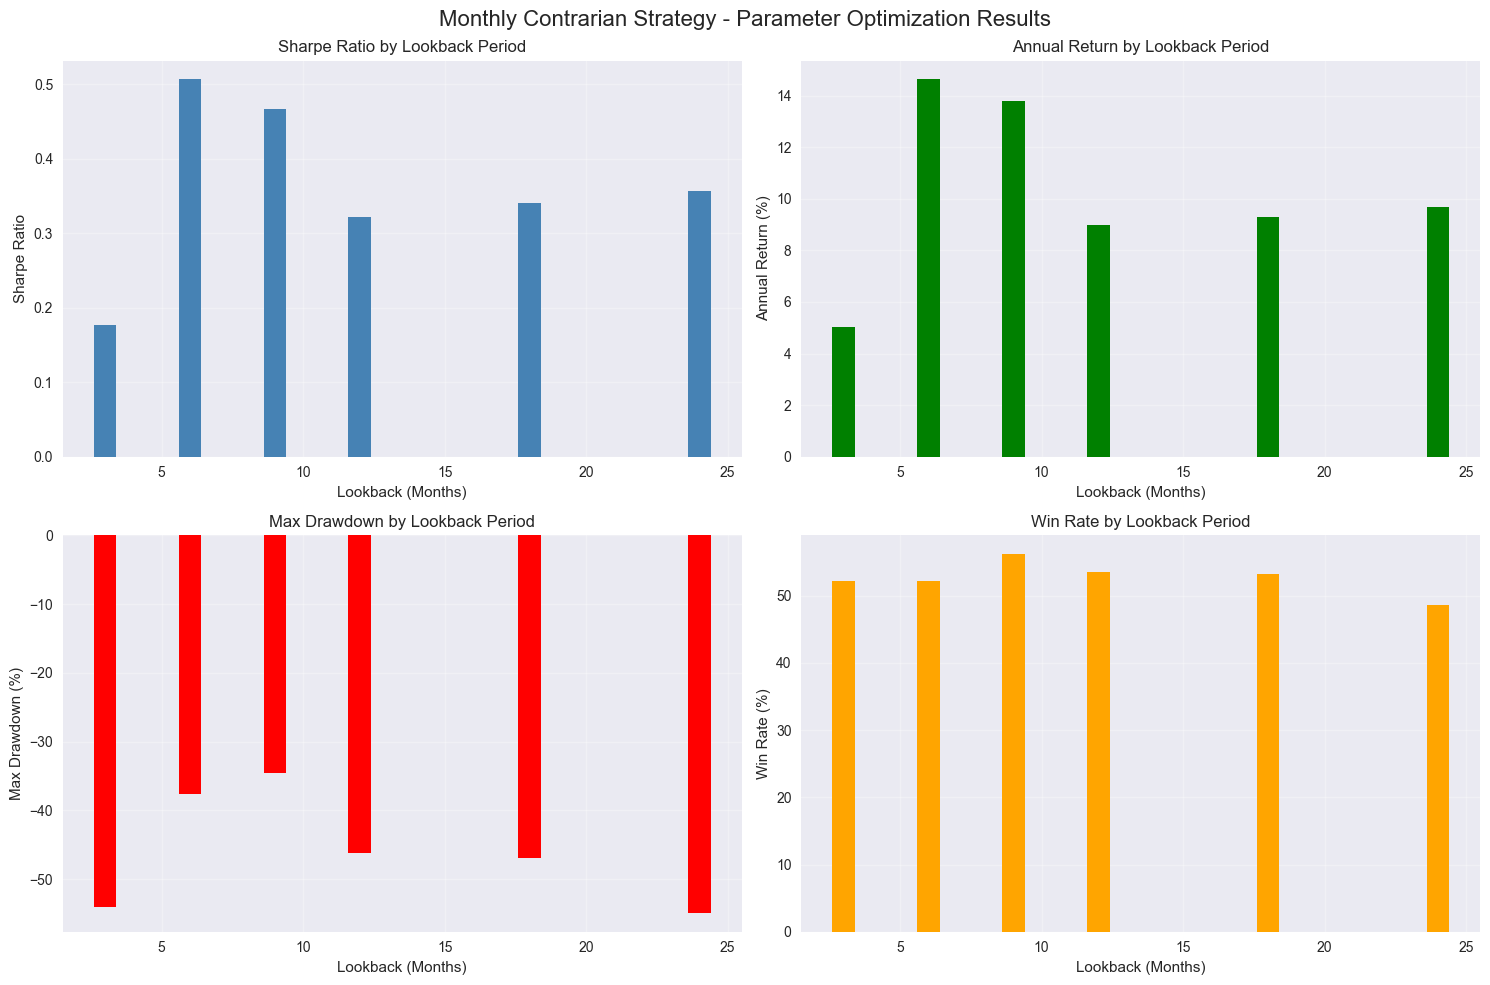

In [9]:
# Performance metrics by lookback period
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Monthly Contrarian Strategy - Parameter Optimization Results', fontsize=16)

# Sharpe Ratio
axes[0,0].bar(results_df['lookback_months'], results_df['sharpe_ratio'], color='steelblue')
axes[0,0].set_title('Sharpe Ratio by Lookback Period')
axes[0,0].set_xlabel('Lookback (Months)')
axes[0,0].set_ylabel('Sharpe Ratio')
axes[0,0].grid(True, alpha=0.3)

# Annual Return
axes[0,1].bar(results_df['lookback_months'], results_df['annual_return']*100, color='green')
axes[0,1].set_title('Annual Return by Lookback Period')
axes[0,1].set_xlabel('Lookback (Months)')
axes[0,1].set_ylabel('Annual Return (%)')
axes[0,1].grid(True, alpha=0.3)

# Max Drawdown
axes[1,0].bar(results_df['lookback_months'], results_df['max_drawdown']*100, color='red')
axes[1,0].set_title('Max Drawdown by Lookback Period')
axes[1,0].set_xlabel('Lookback (Months)')
axes[1,0].set_ylabel('Max Drawdown (%)')
axes[1,0].grid(True, alpha=0.3)

# Win Rate
axes[1,1].bar(results_df['lookback_months'], results_df['win_rate']*100, color='orange')
axes[1,1].set_title('Win Rate by Lookback Period')
axes[1,1].set_xlabel('Lookback (Months)')
axes[1,1].set_ylabel('Win Rate (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Best Strategy Equity Curve

=== BEST STRATEGY ANALYSIS (Lookback = 6 months) ===


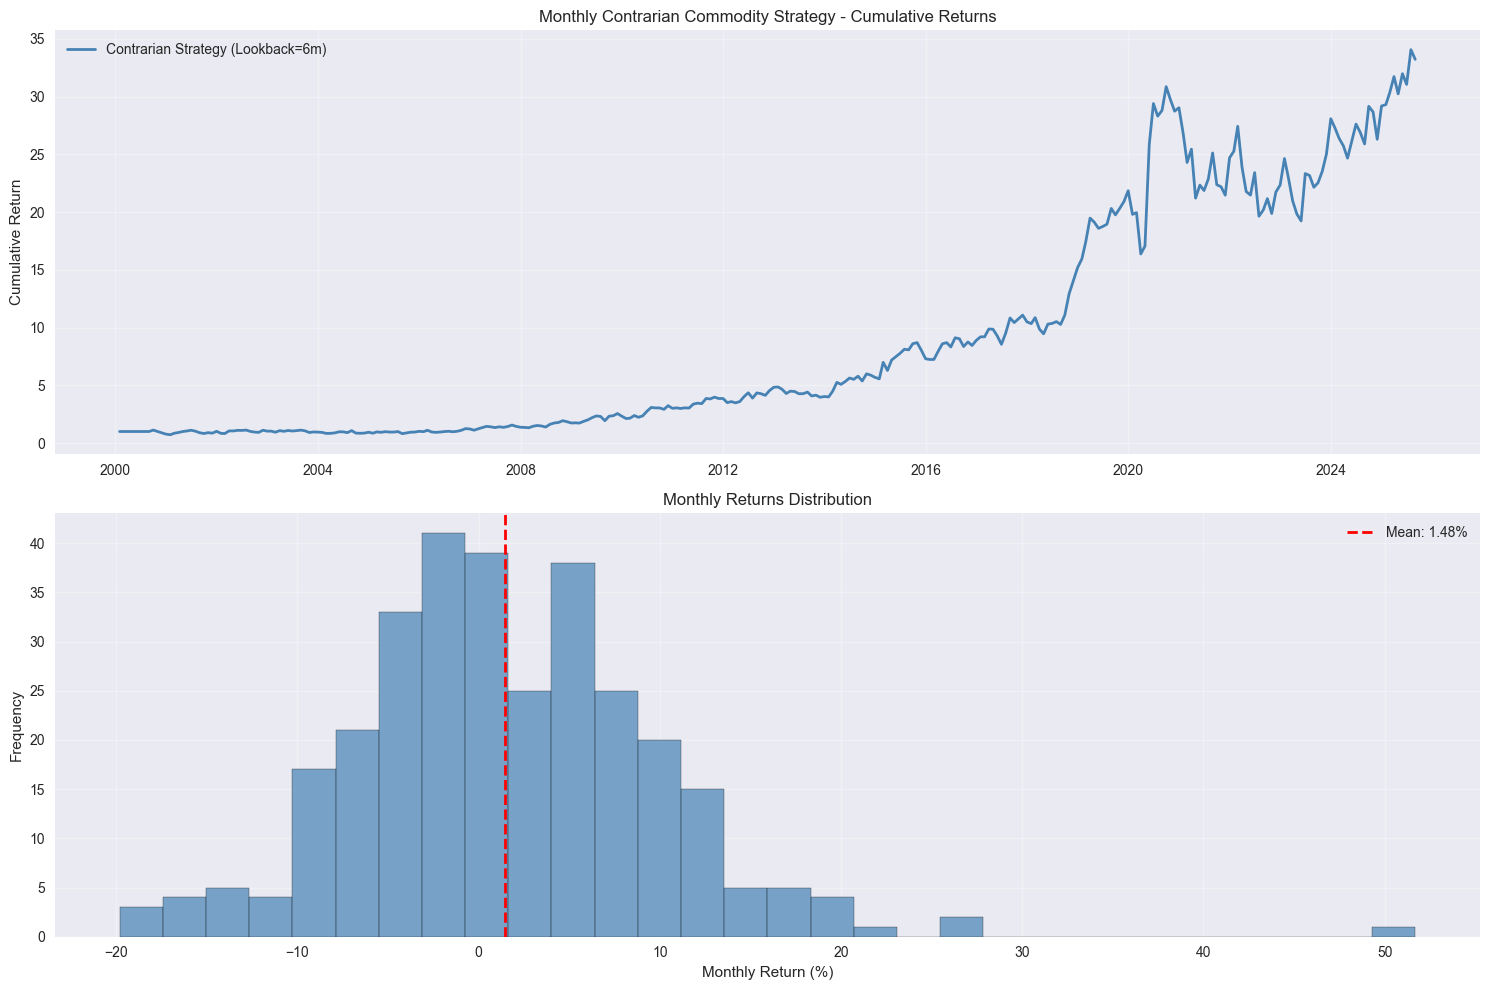


Best Strategy Performance Summary:
Lookback Period: 6.0 months
Total Return: 3223.0%
Annual Return: 14.6%
Annual Volatility: 28.9%
Sharpe Ratio: 0.507
Max Drawdown: -37.7%
Win Rate: 52.3%
Data Period: 25.7 years (308 months)


In [10]:
# Run best strategy and plot equity curve
best_sharpe_idx = results_df['sharpe_ratio'].idxmax()
best_lookback = results_df.loc[best_sharpe_idx, 'lookback_months']

print(f"=== BEST STRATEGY ANALYSIS (Lookback = {best_lookback} months) ===")

# Re-run best strategy
best_results, best_positions = monthly_contrarian_strategy(monthly_prices, int(best_lookback))

# Clean data for plotting
clean_results = best_results.dropna()

# Plot equity curves
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Equity curve
axes[0].plot(clean_results.index, clean_results['cumulative_returns'], 
             linewidth=2, color='steelblue', label=f'Contrarian Strategy (Lookback={best_lookback}m)')
axes[0].set_title('Monthly Contrarian Commodity Strategy - Cumulative Returns')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Monthly returns distribution
monthly_rets = clean_results['strategy_returns'] * 100
axes[1].hist(monthly_rets, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(monthly_rets.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {monthly_rets.mean():.2f}%')
axes[1].set_title('Monthly Returns Distribution')
axes[1].set_xlabel('Monthly Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
best_result = results_df.loc[best_sharpe_idx]
print(f"\nBest Strategy Performance Summary:")
print(f"Lookback Period: {best_result['lookback_months']} months")
print(f"Total Return: {best_result['total_return']:.1%}")
print(f"Annual Return: {best_result['annual_return']:.1%}")
print(f"Annual Volatility: {best_result['annual_volatility']:.1%}")
print(f"Sharpe Ratio: {best_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {best_result['max_drawdown']:.1%}")
print(f"Win Rate: {best_result['win_rate']:.1%}")
print(f"Data Period: {best_result['years_data']:.1f} years ({int(best_result['months_data'])} months)")

## 6. Strategy Summary and Conclusions

In [11]:
print("=== MONTHLY CONTRARIAN STRATEGY SUMMARY ===")
print(f"Universe: {len(commodity_data)} commodity futures")
print(f"Strategy: Quintile-based monthly contrarian (long losers, short winners)")
print(f"Rebalancing: Monthly")
print(f"Data Period: {monthly_prices.index[0].strftime('%Y-%m')} to {monthly_prices.index[-1].strftime('%Y-%m')}")
print(f"\nParameter Testing Results:")
print(f"Lookback periods tested: {lookback_periods}")
print(f"Valid combinations: {len(results_df)}")
print(f"\nBest Sharpe Ratio: {results_df['sharpe_ratio'].max():.3f} (Lookback = {int(results_df.loc[results_df['sharpe_ratio'].idxmax(), 'lookback_months'])} months)")
print(f"Best Annual Return: {results_df['annual_return'].max():.1%} (Lookback = {int(results_df.loc[results_df['annual_return'].idxmax(), 'lookback_months'])} months)")
print(f"Lowest Max Drawdown: {results_df['max_drawdown'].max():.1%} (Lookback = {int(results_df.loc[results_df['max_drawdown'].idxmax(), 'lookback_months'])} months)")

# Save results
results_df.to_csv('../optimization_results.csv', index=False)
print(f"\n✓ Optimization results saved to: ../optimization_results.csv")

=== MONTHLY CONTRARIAN STRATEGY SUMMARY ===
Universe: 24 commodity futures
Strategy: Quintile-based monthly contrarian (long losers, short winners)
Rebalancing: Monthly
Data Period: 2000-01 to 2025-08

Parameter Testing Results:
Lookback periods tested: [3, 6, 9, 12, 18, 24]
Valid combinations: 6

Best Sharpe Ratio: 0.507 (Lookback = 6 months)
Best Annual Return: 14.6% (Lookback = 6 months)
Lowest Max Drawdown: -34.6% (Lookback = 9 months)

✓ Optimization results saved to: ../optimization_results.csv
